In [1]:

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance


from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img


import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import os
import random

# <b>2 <span style='color:#4285f4'>|</span> Reading the Dataset</b>

In [2]:
from zipfile import ZipFile
file_name = ('/content/brain-tumor-mri-dataset.zip')

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
train_dirict = '/content/brain-tumor-mri-dataset/Training'
test_dirict = '/content/brain-tumor-mri-dataset/Testing'

train__paths = []
train__labels = []

for label in os.listdir(train_dirict):
    for image in os.listdir(train_dirict+"//" +label):
        train__paths.append(train_dirict + '//'+label+ '//'+image)
        train__labels.append(label)

train__paths, train__labels = shuffle(train__paths, train__labels)

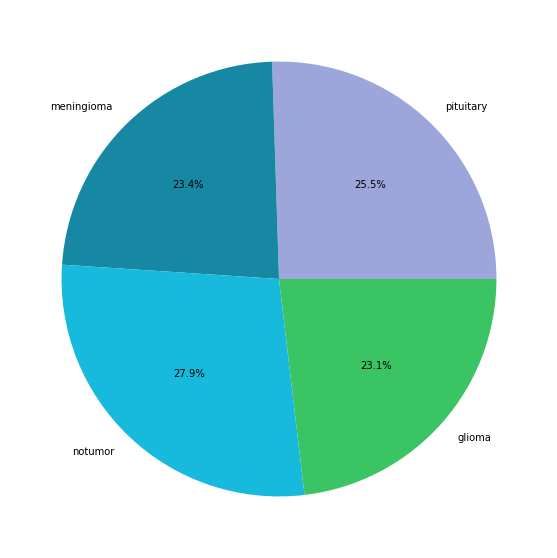

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


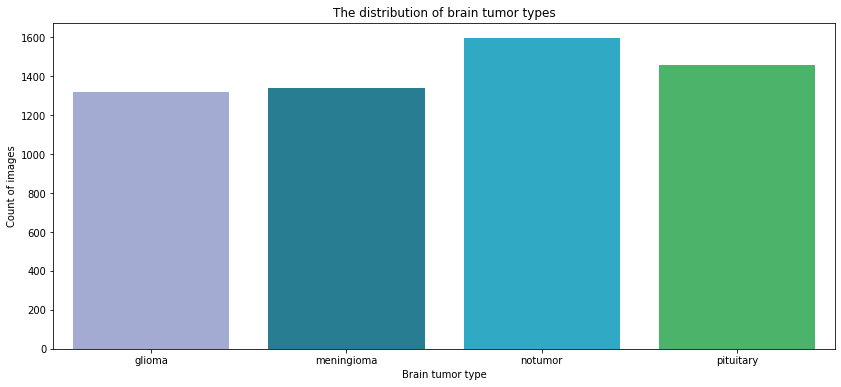

In [4]:
plt.figure(figsize=(10,10))
colors = ['#9ca6db','#1688a4','#17b9dd','#3bc464']
plt.pie([len(os.listdir(train_dirict+"//" +label)) 
        for label in os.listdir(train_dirict)],
         labels=os.listdir(train_dirict),
          colors = colors,
          autopct='%1.1f%%')
plt.show()




plt.figure(figsize=(14,6))
sns.countplot(train__labels, palette=colors)
plt.title('The distribution of brain tumor types')
plt.xlabel('Brain tumor type')
plt.ylabel('Count of images');





In [5]:
test__paths = []
test__labels = []

for label in os.listdir(test_dirict):
    for image in os.listdir(test_dirict+ '//' + label):
        test__paths.append(test_dirict +'//'+label + '//'+image)
        test__labels.append(label)

test__paths, test__labels = shuffle(test__paths, test__labels)

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

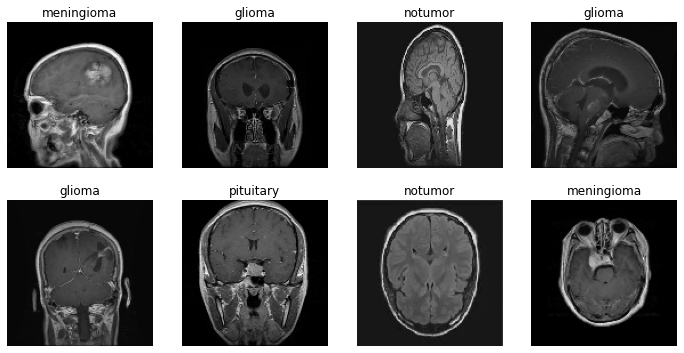

In [7]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train__paths[50:59])
labels = train__labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()


In [8]:
unique__labels = os.listdir(train_dirict)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique__labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique__labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch__paths = paths[x:x+batch_size]
            batch__images = open_images(batch__paths)
            batch__labels = labels[x:x+batch_size]
            batch__labels = encode_label(batch__labels)
            yield batch__images, batch__labels

CNN Model Defination

In [9]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 25088)             0

Training CNN

In [10]:

model.fit(datagen(train__paths, train__labels, batch_size=32, epochs=10), steps_per_epoch=len(train__paths)//32, epochs=10)


Epoch 1/10
178/178 [==============================] - 27s 125ms/step - loss: 0.6917 - accuracy: 0.7159
Epoch 2/10
178/178 [==============================] - 21s 120ms/step - loss: 0.4291 - accuracy: 0.8276
Epoch 3/10
178/178 [==============================] - 22s 123ms/step - loss: 0.3216 - accuracy: 0.8743
Epoch 4/10
178/178 [==============================] - 21s 119ms/step - loss: 0.2571 - accuracy: 0.9026
Epoch 5/10
178/178 [==============================] - 24s 135ms/step - loss: 0.1927 - accuracy: 0.9280
Epoch 6/10
178/178 [==============================] - 23s 128ms/step - loss: 0.1605 - accuracy: 0.9403
Epoch 7/10
178/178 [==============================] - 21s 120ms/step - loss: 0.1142 - accuracy: 0.9579
Epoch 8/10
178/178 [==============================] - 22s 124ms/step - loss: 0.1068 - accuracy: 0.9607
Epoch 9/10
178/178 [==============================] - 22s 126ms/step - loss: 0.0677 - accuracy: 0.9764
Epoch 10/10
178/178 [==============================] - 22s 125ms/step - l

Evaluating the model

In [11]:
train_loss, train_acc = model.evaluate(open_images(train__paths), encode_label(train__labels))
test_loss, test_acc = model.evaluate(open_images(test__paths), encode_label(test__labels))

print('Accuracy in training', train_acc)
print('Training precision', test_acc)

41/41 [==============================] - 1s 12ms/step - loss: 0.3161 - accuracy: 0.9199
Accuracy in training 0.9728641510009766
Training precision 0.9199084639549255


Classification report


In [12]:
predictions = model.predict(open_images(test__paths))
predictions = np.argmax(predictions, axis=1)
print(classification_report(encode_label(test__labels), predictions, target_names=unique__labels))

41/41 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

   pituitary       0.97      0.97      0.97       300
  meningioma       0.76      0.97      0.85       306
     notumor       1.00      0.94      0.97       405
      glioma       0.98      0.78      0.87       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.91      1311
weighted avg       0.93      0.92      0.92      1311



VGG Model

In [13]:
base__model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base__model.layers:
    layer.trainable = False

base__model.layers[-2].trainable = True
base__model.layers[-3].trainable = True
base__model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base__model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique__labels), activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

 Training VGG Model

In [ ]:
batch_size = 20
steps = int(len(train__paths)/batch_size)
epochs = 25
history = model.fit(datagen(train__paths, train__labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/25
285/285 [==============================] - 29s 95ms/step - loss: 0.4500 - sparse_categorical_accuracy: 0.8286
Epoch 2/25
285/285 [==============================] - 30s 101ms/step - loss: 0.2307 - sparse_categorical_accuracy: 0.9093
Epoch 3/25
285/285 [==============================] - 27s 94ms/step - loss: 0.1622 - sparse_categorical_accuracy: 0.9413
Epoch 4/25
285/285 [==============================] - 26s 91ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9605
Epoch 5/25
285/285 [==============================] - 26s 92ms/step - loss: 0.0887 - sparse_categorical_accuracy: 0.9673
Epoch 6/25
285/285 [==============================] - 26s 91ms/step - loss: 0.0540 - sparse_categorical_accuracy: 0.9809
Epoch 7/25
285/285 [==============================] - 26s 93ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9770
Epoch 8/25
285/285 [==============================] - 27s 96ms/step - loss: 0.0496 - sparse_categorical_accuracy: 0.9847
Epoch 9/25
285/285 [===========

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

 Evaluating Model with Test Sample

In [ ]:
batch_size = 32
step = int(len(test__paths)/batch_size)
y__pred = []
y__true = []
for x,y in tqdm(datagen(test__paths, test__labels, batch_size=batch_size, epochs=1), total=step):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y__pred.append(i)
    for i in decode_label(y):
        y__true.append(i)

In [ ]:
print(classification_report(y__true, y__pred))